In [1]:
from src.model.eegnet_variance import EEGNetMultiHeaded
from pytorch_lightning.loggers import CometLogger
from src.datamodule import DataModule, predictDataSet
from src.preprocessing import create_dataset
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.preprocessing import *
from src.noise_addition import zero_signal, add_gaussian_noise
import copy
import random
import pickle

In [2]:
comet_logger = CometLogger(
    api_key="WSATCNWE43zphHslQCTsJKcgk",
    workspace="marwo22",  # Optional
    project_name="bachelors-project"  # Optional
)

CometLogger will be initialized in online mode


In [3]:
# Used this method of sampling, since normal sampling will not work when channels are less than 20
def sample_5_percent(n_channels):
    count = 0
    for _ in range(n_channels):
        if random.randint(0, 19) == 0:
            count += 1
    
    return count

In [4]:
# Adds noise to a single EEG windows. Severity influences the severity of the noise
def add_noise_to_eeg(signal, severity: int, low: int = 0, high: int = 308):
        # Pick random method of adding noise
    random_val = random.randint(0, 2)
        # The amount of channels to add noise to is 10% multiplied by the severity
        # Thus ranging from 10% to 100%
    channels_to_corrupt = int(64 / 10 * severity)


    if random_val == 0: # Gaussian noise
            # Adds Gaussian noise to the entire length of the signal on n_channels. The sd of the noise is 0.25 multiplied by the severity
            # Thus raning from .25 to 2.5
        signal = add_gaussian_noise(signal, .25 * severity, channels_to_corrupt, low, high)
    elif random_val == 1: # Zeroing
            # Each channel has a 5% to be completely zeroed
        samples = sample_5_percent(channels_to_corrupt)
            # Add zero datapoints to n_channels. The percentage of datapoints to zero is 3% multiplied by the severity
            # Thus ranging from 3% to 30%
        signal = zero_signal(signal, channels_to_corrupt - samples, low, high, percentage=3 * severity)
            # If there are channels to fully zero, zero the signal with 100%
            # Note that this can be a previously partially zeroed channel, but that should not really matter
        if samples:
            signal = zero_signal(signal, samples, low, high, percentage=100)
    elif random_val == 2: # Combination of both
            # Add noise to half of the n_channels, and zero the other half
        channels_to_corrupt = int(channels_to_corrupt / 2)
        signal = add_gaussian_noise(signal, .25 * severity, channels_to_corrupt, low, high)
        samples = sample_5_percent(channels_to_corrupt)
        signal = zero_signal(signal, channels_to_corrupt - samples, low, high, percentage=0.03 * severity)
        if samples:
            signal = zero_signal(signal, samples, low, high, percentage=100)

    return signal


In [5]:
# Adds noise to a full training/testing/validation dataset
# Severity_index can be any value from 0 to, and including, 10.
# This index will influence the amount and severity of the noise
def add_noise_to_dataset(dataset, severity_index, low: int = 0, high: int = 308):
        # No noise is added when severity==0
    if (severity_index == 0):
        return dataset

    length = len(dataset[0])
        # Add noise to 5%  * severityIndex of samples in the dataset. It can thus range from 5% to 50%
    episodes_to_corrupt = random.sample(range(0, length), int(0.05 * length))
        # Add noise to the samples
    for episode in episodes_to_corrupt:
        dataset[0][episode] = add_noise_to_eeg(dataset[0][episode], severity_index)

    return dataset



Text(0.5, 0.98, 'The effect of medium localized noise on the first 5 channels')

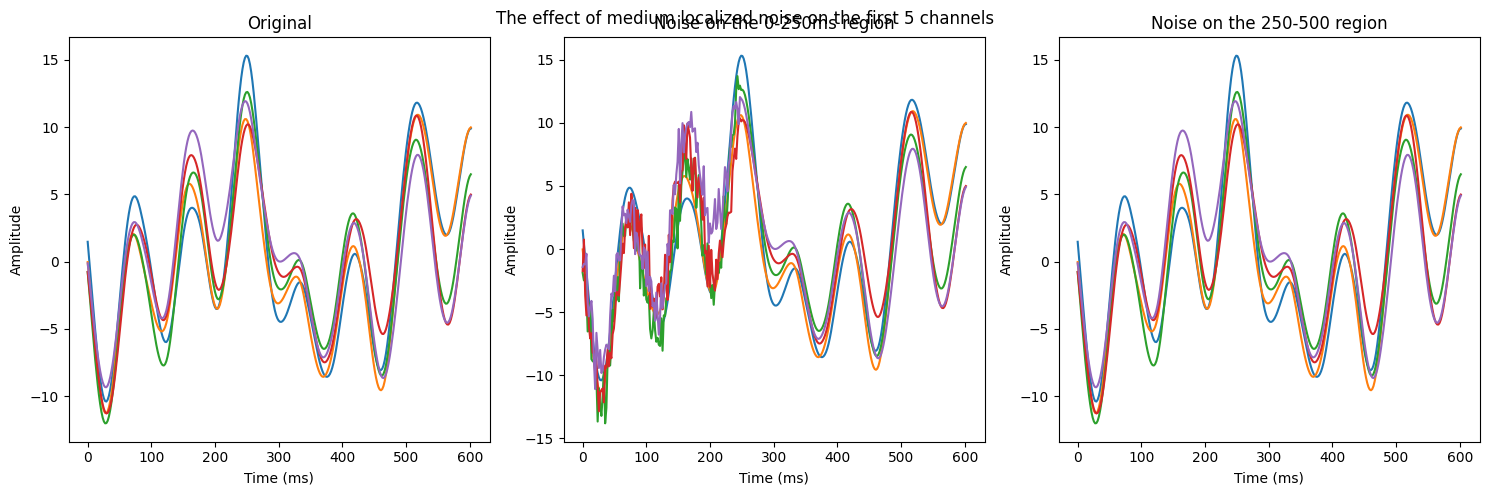

In [30]:
# Plot the first 5 channels of the original signal, localized noise on 0-250ms, and localized noise on 250-500ms

train, val, test = create_dataset('./src/pickle_df', 1)

train_copy = copy.deepcopy(train)
left_noise = add_noise_to_eeg(train_copy[0][0], 5, low = 0, high = 127)

train_copy = copy.deepcopy(train)
right_noise = add_noise_to_eeg(train_copy[0][0], 5, low = 128, high = 255)

duration = 308 / 512 * 1000
t = np.linspace(0, duration, 308)

figure, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(t, train[0][0][0], label='1')
axes[0].plot(t, train[0][0][1], label='2')
axes[0].plot(t, train[0][0][2], label="3")
axes[0].plot(t, train[0][0][3], label="4")
axes[0].plot(t, train[0][0][4], label="5")
axes[0].set_xlabel("Time (ms)")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Original")

axes[1].plot(t, left_noise[0], label='1')
axes[1].plot(t, left_noise[1], label='2')
axes[1].plot(t, left_noise[2], label="3")
axes[1].plot(t, left_noise[3], label="4")
axes[1].plot(t, left_noise[4], label="5")
axes[1].set_xlabel("Time (ms)")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Noise on the 0-250ms region")

axes[2].plot(t, right_noise[0], label='1')
axes[2].plot(t, right_noise[1], label='2')
axes[2].plot(t, right_noise[2], label="3")
axes[2].plot(t, right_noise[3], label="4")
axes[2].plot(t, right_noise[4], label="5")
axes[2].set_xlabel("Time (ms)")
axes[2].set_ylabel("Amplitude")
axes[2].set_title("Noise on the 250-500 region")

figure.tight_layout()
figure.suptitle("The effect of medium localized noise on the first 5 channels")
# Title and subtitle overlap, but its only for visualization

In [6]:
# Currently, I don't check the SHAP values for the highest influence area, but rather take the theoratical location of highest influence, which happens at around 250-500ms

# 0-250ms for low effect
# 250-500ms for high effect

# Tests for medium noise(5) on the low effect region, and medium noise on the high effect region

variances = [[] for _ in range(2)]
accuracies = [[] for _ in range(2)]

for j in range(6):  
    # Load in the datasets with the current participant as test set
    train, val, test = create_dataset('./src/pickle_df', j + 1)

    for i in range(2):
        # Take deep copies
        train_copy = copy.deepcopy(train)
        val_copy = copy.deepcopy(val)
        test_copy = copy.deepcopy(test)
        
        # Add noise to the deep copies. If i is 0, noise is added to the lower end, when it is 1, it is added to the higher end
        # For this experiment, the intensity value is 5, resulting in a 'medium' level of noise
        train_copy = add_noise_to_dataset(train_copy, 5, low = i * 128, high = (i + 1) * 128 - 1)
        val_copy = add_noise_to_dataset(val_copy, 5, low = i * 128, high = (i + 1) * 128 - 1)
        test_copy = add_noise_to_dataset(test_copy, 5, low = i * 128, high = (i + 1) * 128 - 1)

        dm = DataModule(train=train_copy, val=val_copy, test=test_copy, batch_size=16)

        model = EEGNetMultiHeaded(chunk_size=308,
                                num_electrodes=64,
                                dropout=0.5,
                                kernel_1=64,
                                kernel_2=16,
                                F1=8,
                                F2=16,
                                D=2,
                                num_classes=2)
        # Train for 25 epochs for this example
        # Final one for results wil run for 50 most likely
        trainer = pl.Trainer(
            max_epochs=25,
            logger=comet_logger
        )

        # Fit and test model
        trainer.fit(model, datamodule=dm)
        test_results = trainer.test(model, datamodule=dm)
        
        # Capture the testing variance and accuracy
        variances[i].append(test_results[0]['overall_var'])
        accuracies[i].append(test_results[0]['test_acc'])

        # Save them to a pkl file
        with open('results_pickled/localized_variances.pkl', 'wb') as f:
            pickle.dump(variances, f)

        with open('results_pickled/localized_accuracies.pkl', 'wb') as f:
            pickle.dump(accuracies, f)
    
    # Just to visualize progress easier, the output is very messy
    print("\n\n\n\n\nFinished" + str(j) + "\n\n\n\n\n")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 80.95it/s, v_num=c02b]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 80.83it/s, v_num=c02b]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (5.071012496948242, 63.877166748046875)
COMET INFO:     val_loss [1702]    : (5.678942680358887, 63.567935943603516)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (1.25 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET I

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)
COMET INFO: Uploading 162 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 81.70it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 28.46it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21477717487772618    │
│       incorrect_var       │    0.23748363990080418    │
│        overall_var        │    0.21888325120754168    │
│         test_acc          │    0.8160919547080994     │
│         test_loss         │    11.507555961608887     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21477717487772618
COMET INFO:     incorrect_var : 0.23748363990080418
COMET INFO:     overall_var   : 0.21888325120754168
COMET INFO:     test_acc      : 0.8160919547080994
COMET INFO:     test_loss     : 11.507555961608887
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 80.13it/s, v_num=c02b]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 80.00it/s, v_num=c02b]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (6.436781883239746, 72.06332397460938)
COMET INFO:     val_loss [1702]    : (5.801584720611572, 54.61112976074219)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 87.82it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 28.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21258745952776956    │
│       incorrect_var       │    0.2361426494217345     │
│        overall_var        │    0.21564900437619722    │
│         test_acc          │    0.8678160905838013     │
│         test_loss         │    10.345016479492188     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21258745952776956
COMET INFO:     incorrect_var : 0.2361426494217345
COMET INFO:     overall_var   : 0.21564900437619722
COMET INFO:     test_acc      : 0.8678160905838013
COMET INFO:     test_loss     : 10.345016479492188
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished0







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\82e72254de234781a173b727af6fc02b\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 426/426 [00:05<00:00, 81.16it/s, v_num=c02b]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 426/426 [00:05<00:00, 81.03it/s, v_num=c02b]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10650] : (0.4829566776752472, 49.28501892089844)
COMET INFO:     val_loss [1702]    : (0.1793377548456192, 49.674190521240234)


COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 430 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 96.99it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.33it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21639173598139674    │
│       incorrect_var       │    0.23411122439439316    │
│        overall_var        │    0.22013732179723405    │
│         test_acc          │     0.770370364189148     │
│         test_loss         │    12.809051513671875     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21639173598139674
COMET INFO:     incorrect_var : 0.23411122439439316
COMET INFO:     overall_var   : 0.22013732179723405
COMET INFO:     test_acc      : 0.770370364189148
COMET INFO:     test_loss     : 12.809051513671875
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



Epoch 24: 100%|██████████| 426/426 [00:05<00:00, 81.57it/s, v_num=c02b]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 426/426 [00:05<00:00, 81.47it/s, v_num=c02b]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10650] : (0.29468709230422974, 54.850948333740234)
COMET INFO:     val_loss [1702]    : (0.2023395597934723, 49.93434143066406)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 428 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 82.75it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 29.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │     0.207603594588684     │
│       incorrect_var       │    0.23151055300576348    │
│        overall_var        │    0.21182287465780975    │
│         test_acc          │    0.8185185194015503     │
│         test_loss         │     11.39797592163086     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.207603594588684
COMET INFO:     incorrect_var : 0.23151055300576348
COMET INFO:     overall_var   : 0.21182287465780975
COMET INFO:     test_acc      : 0.8185185194015503
COMET INFO:     test_loss     : 11.39797592163086
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished1







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\82e72254de234781a173b727af6fc02b\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 80.92it/s, v_num=c02b]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 80.75it/s, v_num=c02b]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10725] : (2.1478943824768066, 57.84393310546875)
COMET INFO:     val_loss [1702]    : (0.30972346663475037, 50.570518493652344)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 84.12it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 28.80it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20731085342146413    │
│       incorrect_var       │    0.2188768718632003     │
│        overall_var        │     0.210805769831762     │
│         test_acc          │    0.6737451553344727     │
│         test_loss         │     16.32390022277832     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20731085342146413
COMET INFO:     incorrect_var : 0.2188768718632003
COMET INFO:     overall_var   : 0.210805769831762
COMET INFO:     test_acc      : 0.6737451553344727
COMET INFO:     test_loss     : 16.32390022277832
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True
TP

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 80.68it/s, v_num=c02b]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 80.58it/s, v_num=c02b]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10725] : (1.3782106637954712, 13826.7626953125)
COMET INFO:     val_loss [1702]    : (0.47179096937179565, 48.220428466796875)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 91.65it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 29.28it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20591761342753664    │
│       incorrect_var       │    0.22558299980914878    │
│        overall_var        │    0.2100276656513566     │
│         test_acc          │    0.7789575457572937     │
│         test_loss         │    13.055922508239746     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20591761342753664
COMET INFO:     incorrect_var : 0.22558299980914878
COMET INFO:     overall_var   : 0.2100276656513566
COMET INFO:     test_acc      : 0.7789575457572937
COMET INFO:     test_loss     : 13.055922508239746
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished2







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\82e72254de234781a173b727af6fc02b\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 431/431 [00:05<00:00, 81.68it/s, v_num=c02b]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 431/431 [00:05<00:00, 81.54it/s, v_num=c02b]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10775] : (0.26009050011634827, 68.3880844116211)
COMET INFO:     val_loss [1652]    : (3.1943745613098145, 54.57646179199219)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\p

Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 94.67it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.95it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20415456051271022    │
│       incorrect_var       │    0.22086481716539658    │
│        overall_var        │    0.20782245701256813    │
│         test_acc          │    0.7918251156806946     │
│         test_loss         │    12.098665237426758     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20415456051271022
COMET INFO:     incorrect_var : 0.22086481716539658
COMET INFO:     overall_var   : 0.20782245701256813
COMET INFO:     test_acc      : 0.7918251156806946
COMET INFO:     test_loss     : 12.098665237426758
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



Epoch 24: 100%|██████████| 431/431 [00:05<00:00, 80.41it/s, v_num=c02b]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 431/431 [00:05<00:00, 80.28it/s, v_num=c02b]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10775] : (0.26903724670410156, 51.14180374145508)
COMET INFO:     val_loss [1652]    : (2.9757680892944336, 55.97869110107422)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 84.52it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.06it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.1733530588932733     │
│       incorrect_var       │    0.20580077062440075    │
│        overall_var        │    0.1795708943554997     │
│         test_acc          │    0.8146387934684753     │
│         test_loss         │    11.070716857910156     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.1733530588932733
COMET INFO:     incorrect_var : 0.20580077062440075
COMET INFO:     overall_var   : 0.1795708943554997
COMET INFO:     test_acc      : 0.8146387934684753
COMET INFO:     test_loss     : 11.070716857910156
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished3







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\82e72254de234781a173b727af6fc02b\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 80.70it/s, v_num=c02b]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 80.56it/s, v_num=c02b]

COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (4.272603988647461, 56.07465362548828)
COMET INFO:     val_loss [1652]    : (4.499341011047363, 51.11737060546875)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 152 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test

Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 85.50it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 30.42it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.19735505246587792    │
│       incorrect_var       │    0.22429800799538477    │
│        overall_var        │    0.20169805876001756    │
│         test_acc          │    0.8334817290306091     │
│         test_loss         │    10.919449806213379     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.19735505246587792
COMET INFO:     incorrect_var : 0.22429800799538477
COMET INFO:     overall_var   : 0.20169805876001756
COMET INFO:     test_acc      : 0.8334817290306091
COMET INFO:     test_loss     : 10.919449806213379
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: Tru

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 80.42it/s, v_num=c02b]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 80.29it/s, v_num=c02b]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (4.984899520874023, 56.574981689453125)
COMET INFO:     val_loss [1652]    : (6.265359401702881, 51.55818176269531)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 84.28it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 30.14it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.19973586481221903    │
│       incorrect_var       │    0.22838327612729056    │
│        overall_var        │    0.20515799530361342    │
│         test_acc          │    0.8165627717971802     │
│         test_loss         │    10.934222221374512     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.19973586481221903
COMET INFO:     incorrect_var : 0.22838327612729056
COMET INFO:     overall_var   : 0.20515799530361342
COMET INFO:     test_acc      : 0.8165627717971802
COMET INFO:     test_loss     : 10.934222221374512
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished4







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\82e72254de234781a173b727af6fc02b\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 421/421 [00:05<00:00, 78.86it/s, v_num=c02b]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 421/421 [00:05<00:00, 78.75it/s, v_num=c02b]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10525] : (2.781588315963745, 67.76464080810547)
COMET INFO:     val_loss [1702]    : (2.5895347595214844, 47.47156524658203)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 85 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\p

Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 92.25it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 30.40it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22714279120160658    │
│       incorrect_var       │    0.23071448207373918    │
│        overall_var        │    0.22904522529720395    │
│         test_acc          │    0.5027223229408264     │
│         test_loss         │    18.979938507080078     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22714279120160658
COMET INFO:     incorrect_var : 0.23071448207373918
COMET INFO:     overall_var   : 0.22904522529720395
COMET INFO:     test_acc      : 0.5027223229408264
COMET INFO:     test_loss     : 18.979938507080078
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



Epoch 24: 100%|██████████| 421/421 [00:05<00:00, 79.71it/s, v_num=c02b]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 421/421 [00:05<00:00, 79.59it/s, v_num=c02b]

COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10525] : (2.036742925643921, 57.29621887207031)
COMET INFO:     val_loss [1702]    : (2.5362777709960938, 52.02336120605469)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 84 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 82.26it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 29.71it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21274959521647543    │
│       incorrect_var       │    0.2194308864382726     │
│        overall_var        │    0.21748039826831886    │
│         test_acc          │    0.2858439087867737     │
│         test_loss         │    25.627830505371094     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/82e72254de234781a173b727af6fc02b
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21274959521647543
COMET INFO:     incorrect_var : 0.2194308864382726
COMET INFO:     overall_var   : 0.21748039826831886
COMET INFO:     test_acc      : 0.2858439087867737
COMET INFO:     test_loss     : 25.627830505371094
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages







Finished5







[0.2147320139843879, 0.20661813876879923]
[0.7313727736473083, 0.7303896049658457]


Text(0.5, 1.0, 'Effect on accuracy')

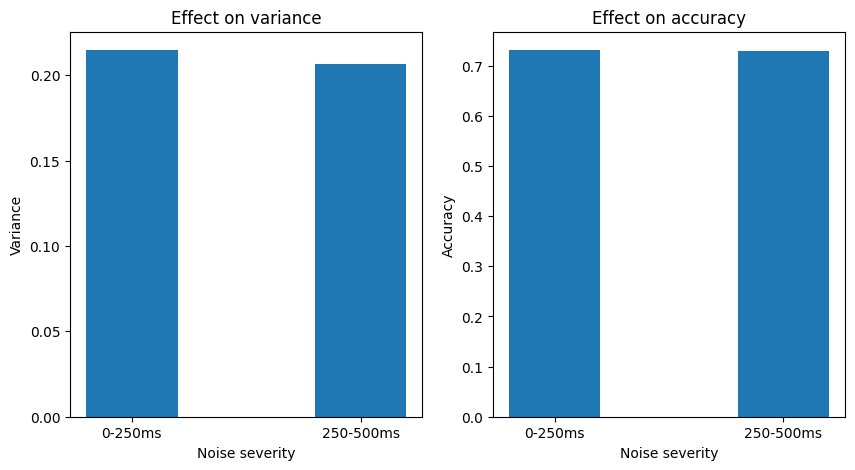

In [9]:
# Load in the .pkl files
with open('results_pickled/localized_accuracies.pkl', 'rb') as f:
    accuracies = pickle.load(f)

with open('results_pickled/localized_variances.pkl', 'rb') as f:
    variances = pickle.load(f)

# Take the mean of the accuracies and variances
for i in range(2):
    variances[i] = np.asarray(variances[i]).mean()
    accuracies[i] = np.asarray(accuracies[i]).mean()

print(variances)
print(accuracies)

# Create a barplot of the variances and accuracies
figure, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].bar(["0-250ms", "250-500ms"], variances, width = 0.4)
axes[0].set_xlabel("Noise severity")
axes[0].set_ylabel("Variance")
axes[0].set_title("Effect on variance")
axes[1].bar(["0-250ms", "250-500ms"], accuracies, width = 0.4)
axes[1].set_xlabel("Noise severity")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Effect on accuracy")

# As can be seen, there is practically no difference between the two noise locations
# Variance and accuracy are almost identical